<a href="https://colab.research.google.com/github/ElenaSelishcheva/ML_course_7_semester/blob/main/Homework_%E2%84%968.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 0 Loss D.: 0.5801420211791992
Epoch: 0 Loss G.: 0.6563864946365356
Epoch: 10 Loss D.: 0.5605331659317017
Epoch: 10 Loss G.: 2.551457405090332
Epoch: 20 Loss D.: 0.6752435564994812
Epoch: 20 Loss G.: 0.7103399634361267
Epoch: 30 Loss D.: 0.6337364912033081
Epoch: 30 Loss G.: 0.8447215557098389
Epoch: 40 Loss D.: 0.8136042356491089
Epoch: 40 Loss G.: 0.7490384578704834
Epoch: 50 Loss D.: 0.6243141889572144
Epoch: 50 Loss G.: 1.02497398853302
Epoch: 60 Loss D.: 0.6196900606155396
Epoch: 60 Loss G.: 1.0372610092163086
Epoch: 70 Loss D.: 0.6940687298774719
Epoch: 70 Loss G.: 1.1680305004119873
Epoch: 80 Loss D.: 0.7193958759307861
Epoch: 80 Loss G.: 0.6841815114021301
Epoch: 90 Loss D.: 0.6356703639030457
Epoch: 90 Loss G.: 0.7661444544792175
Epoch: 100 Loss D.: 0.6956754922866821
Epoch: 100 Loss G.: 0.7870768308639526
Epoch: 110 Loss D.: 0.7873983383178711
Epoch: 110 Loss G.: 0.6507318019866943
Epoch: 120 Loss D.: 0.6887161135673523
Epoch: 120 Loss G.: 0.664993941783905
Epoch: 130 L

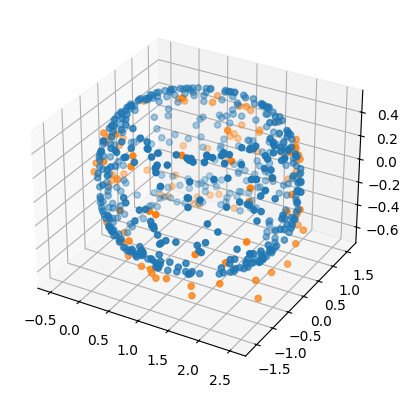

In [ ]:
"""Генерация точек на графике функции
по ограниченному множеству её точек
с помощью нейронной генеративно-состязательной сети.

"""

"""
Сеть должна научиться генерировать точки на трёхмерной
поверхности - верхней полусфере с центром (1,1,0) и радиусом 1.
Такая задача выбрана, потому что для обучения сети обработке
изображений или текстов обучение идёт дольше и менее стабильно.
"""

import math
import random

import torch
from torch import nn

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

random.seed(17)
torch.manual_seed(19)

# параметры тора
R = 1.0  # внешний радиус (расстояние от центра тора до центра трубки)
r = 0.5  # радиус трубки

# положение центра тора
center = torch.tensor([R, 0.0, 0.0])  # или любое другое значение (a, b, c)

# создаем обучающую выборку
N = 512  # размер выборки
train_dataset = torch.zeros((N, 3))
curr_len = 0

while curr_len < N:
    # генерируем параметры u и v
    u = random.uniform(0, 2 * math.pi)  # угол вокруг оси тора
    v = random.uniform(-math.pi / 2, math.pi / 2)  # угол, определяющий высоту на трубке тора

    # вычисляем координаты (x, y, z) для тора
    x = (R + r * math.cos(v)) * math.cos(u) + center[0]  # смещение по x
    y = (R + r * math.cos(v)) * math.sin(u) + center[1]  # смещение по y
    z = r * math.sin(v) + center[2]  # смещение по z

    # сохраняем точку в выборке
    train_dataset[curr_len, 0] = x
    train_dataset[curr_len, 1] = y
    train_dataset[curr_len, 2] = z
    curr_len += 1

# делаем номер класса для примеров из обучающей выборки
# единичным
train_labels = torch.ones(N)

train_set = [(train_dataset[i], train_labels[i]) for i in range(N)]

# готовим загрузчик данных
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

hidden_param_num = 4

# класс-дискриминатор
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # на входе --- 3 значения (координаты)
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            # на выходе --- 1 значение (0 --- пример из выборки, 1 --- сгенерированный)
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

# класс генератора точек.
# Принимает два случайных значения,
# выдаёт координаты точки на полусфере
# (три значения, связанных между собой)
class Generator(nn.Module):
    def __init__(self, hidden_param_num):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(hidden_param_num, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3))

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()
generator = Generator(hidden_param_num)

# параметры обучения: скорость, число эпох, функция потерь
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

# для каждой эпохи:
for epoch in range(num_epochs):
    for n, (real_samples, real_samples_1d) in enumerate(train_loader):
        # данные для обучения дискриминатора
        real_samples_labels = real_samples_1d.view(batch_size, 1)
        latent_space_samples = torch.randn((batch_size, hidden_param_num))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size,1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels,
                                        generated_samples_labels))

        # обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator,
                                           all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, hidden_param_num))

        # обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated,
                                       real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

    # выводим значения функций потерь
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
        print(f"Epoch: {epoch} Loss G.: {loss_generator}")

# строим примеры точек сферы
latent_space_samples = torch.randn((100, hidden_param_num))
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(train_dataset[:, 0], train_dataset[:, 1], train_dataset[:, 2], 'b')
ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], 'r')
plt.show()


In [ ]:
latent_space_samples = torch.randn((100, hidden_param_num))
generated_samples = generator(latent_space_samples)

distances = torch.sqrt((generated_samples[:, 0] - center[0])**2 +
                       (generated_samples[:, 1] - center[1])**2 +
                       (generated_samples[:, 2] - center[2])**2)

# расстояние до центра составляет R +- r
# строим ожидаемые границы
mean_distance = torch.mean(distances)
std_distance = torch.std(distances)

# ожидаемое близкое расстояние от центра
expected_distance = R
mean_distance_to_surface = mean_distance - expected_distance  # среднее расстояние от поверхности

print(f"Mean distance to the center: {mean_distance}")
print(f"Standard deviation of distance: {std_distance}")
print(f"Mean distance to the expected surface: {mean_distance_to_surface}")

Mean distance to the center: 1.4268977642059326
Standard deviation of distance: 0.14731113612651825
Mean distance to the expected surface: 0.4268977642059326


### Влияние скрытых параметров

Number of hidden parameters: 6
Epoch: 0 Loss D.: 0.4365663528442383
Epoch: 0 Loss G.: 5.65723991394043
Epoch: 10 Loss D.: 0.06528975814580917
Epoch: 10 Loss G.: 4.904201984405518
Epoch: 20 Loss D.: 0.08488281816244125
Epoch: 20 Loss G.: 5.981462001800537
Epoch: 30 Loss D.: 0.26387524604797363
Epoch: 30 Loss G.: 2.851565361022949
Epoch: 40 Loss D.: 0.11723567545413971
Epoch: 40 Loss G.: 3.0891735553741455
Epoch: 50 Loss D.: 0.2370438277721405
Epoch: 50 Loss G.: 2.129861831665039
Epoch: 60 Loss D.: 0.34727752208709717
Epoch: 60 Loss G.: 2.4267261028289795
Epoch: 70 Loss D.: 0.14983277022838593
Epoch: 70 Loss G.: 2.244460105895996
Epoch: 80 Loss D.: 0.37342435121536255
Epoch: 80 Loss G.: 2.122831106185913
Epoch: 90 Loss D.: 0.38579776883125305
Epoch: 90 Loss G.: 2.335679769515991
Epoch: 100 Loss D.: 0.3059130609035492
Epoch: 100 Loss G.: 1.6915205717086792
Epoch: 110 Loss D.: 0.5632324814796448
Epoch: 110 Loss G.: 2.177501678466797
Epoch: 120 Loss D.: 0.33120104670524597
Epoch: 120 Loss G

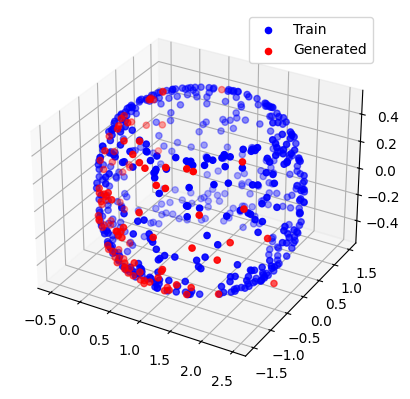

Mean distance to the center: 1.4012740850448608
Standard deviation of distance: 0.10548082739114761
Mean distance to the expected surface: 0.40127408504486084
Number of hidden parameters: 8
Epoch: 0 Loss D.: 0.2663070857524872
Epoch: 0 Loss G.: 2.891385555267334
Epoch: 10 Loss D.: 0.11509277671575546
Epoch: 10 Loss G.: 6.022698879241943
Epoch: 20 Loss D.: 0.06731217354536057
Epoch: 20 Loss G.: 5.517618656158447
Epoch: 30 Loss D.: 0.049350254237651825
Epoch: 30 Loss G.: 4.633624076843262
Epoch: 40 Loss D.: 0.08959046751260757
Epoch: 40 Loss G.: 4.109094619750977
Epoch: 50 Loss D.: 0.11030375212430954
Epoch: 50 Loss G.: 3.0529160499572754
Epoch: 60 Loss D.: 0.22151193022727966
Epoch: 60 Loss G.: 3.196506977081299
Epoch: 70 Loss D.: 0.1756964474916458
Epoch: 70 Loss G.: 2.3881125450134277
Epoch: 80 Loss D.: 0.22421686351299286
Epoch: 80 Loss G.: 2.6274640560150146
Epoch: 90 Loss D.: 0.1332584023475647
Epoch: 90 Loss G.: 2.4990148544311523
Epoch: 100 Loss D.: 0.29075324535369873
Epoch: 100

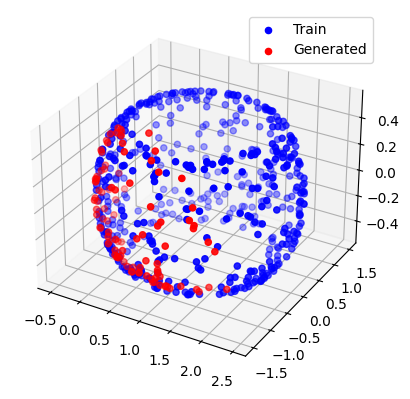

Mean distance to the center: 1.3914390802383423
Standard deviation of distance: 0.12134555727243423
Mean distance to the expected surface: 0.3914390802383423
Number of hidden parameters: 16
Epoch: 0 Loss D.: 0.3968032896518707
Epoch: 0 Loss G.: 4.274866580963135
Epoch: 10 Loss D.: 0.02545386366546154
Epoch: 10 Loss G.: 5.005692005157471
Epoch: 20 Loss D.: 0.01582442782819271
Epoch: 20 Loss G.: 5.149951934814453
Epoch: 30 Loss D.: 0.038622647523880005
Epoch: 30 Loss G.: 5.469550609588623
Epoch: 40 Loss D.: 0.1555252969264984
Epoch: 40 Loss G.: 5.792870998382568
Epoch: 50 Loss D.: 0.043809082359075546
Epoch: 50 Loss G.: 4.561722755432129
Epoch: 60 Loss D.: 0.10899136960506439
Epoch: 60 Loss G.: 4.683021545410156
Epoch: 70 Loss D.: 0.049503229558467865
Epoch: 70 Loss G.: 4.484704971313477
Epoch: 80 Loss D.: 0.05590685456991196
Epoch: 80 Loss G.: 3.807985782623291
Epoch: 90 Loss D.: 0.07646723091602325
Epoch: 90 Loss G.: 3.125659704208374
Epoch: 100 Loss D.: 0.2267201542854309
Epoch: 100 L

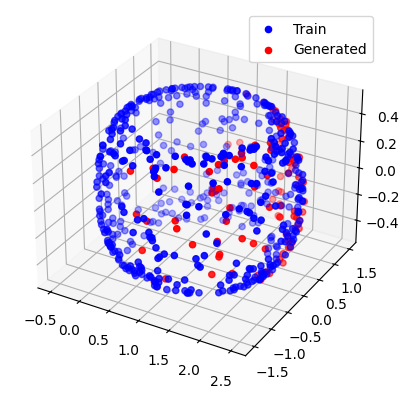

Mean distance to the center: 1.3947585821151733
Standard deviation of distance: 0.09225630760192871
Mean distance to the expected surface: 0.39475858211517334
Number of hidden parameters: 32
Epoch: 0 Loss D.: 0.7832626700401306
Epoch: 0 Loss G.: 1.279973030090332
Epoch: 10 Loss D.: 0.28845393657684326
Epoch: 10 Loss G.: 3.7713890075683594
Epoch: 20 Loss D.: 0.06839461624622345
Epoch: 20 Loss G.: 4.633171081542969
Epoch: 30 Loss D.: 0.13159030675888062
Epoch: 30 Loss G.: 7.135548114776611
Epoch: 40 Loss D.: 0.03288254141807556
Epoch: 40 Loss G.: 5.515739440917969
Epoch: 50 Loss D.: 0.19398300349712372
Epoch: 50 Loss G.: 5.328550338745117
Epoch: 60 Loss D.: 0.027753222733736038
Epoch: 60 Loss G.: 4.980743408203125
Epoch: 70 Loss D.: 0.0756332129240036
Epoch: 70 Loss G.: 3.816589593887329
Epoch: 80 Loss D.: 0.1162809357047081
Epoch: 80 Loss G.: 3.8135390281677246
Epoch: 90 Loss D.: 0.17141976952552795
Epoch: 90 Loss G.: 3.1858139038085938
Epoch: 100 Loss D.: 0.2226584553718567
Epoch: 100 

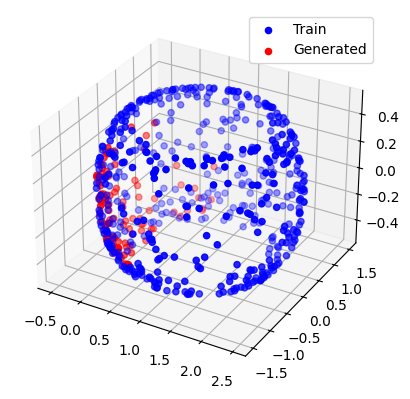

Mean distance to the center: 1.3903324604034424
Standard deviation of distance: 0.10800527036190033
Mean distance to the expected surface: 0.3903324604034424
Number of hidden parameters: 64
Epoch: 0 Loss D.: 0.26785808801651
Epoch: 0 Loss G.: 3.4266600608825684
Epoch: 10 Loss D.: 0.024849722161889076
Epoch: 10 Loss G.: 6.06727409362793
Epoch: 20 Loss D.: 0.31888914108276367
Epoch: 20 Loss G.: 3.9134039878845215
Epoch: 30 Loss D.: 0.05048459395766258
Epoch: 30 Loss G.: 4.426190376281738
Epoch: 40 Loss D.: 0.17843636870384216
Epoch: 40 Loss G.: 5.046060562133789
Epoch: 50 Loss D.: 0.26665908098220825
Epoch: 50 Loss G.: 3.934413433074951
Epoch: 60 Loss D.: 0.11048603057861328
Epoch: 60 Loss G.: 4.346231937408447
Epoch: 70 Loss D.: 0.2827932834625244
Epoch: 70 Loss G.: 4.553647518157959
Epoch: 80 Loss D.: 0.09881456196308136
Epoch: 80 Loss G.: 3.9423298835754395
Epoch: 90 Loss D.: 0.20324739813804626
Epoch: 90 Loss G.: 3.8600642681121826
Epoch: 100 Loss D.: 0.1370277851819992
Epoch: 100 Lo

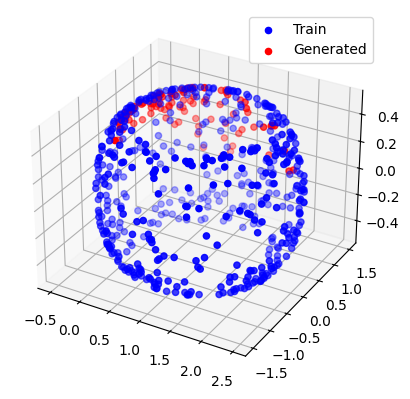

Mean distance to the center: 1.312313437461853
Standard deviation of distance: 0.11662068217992783
Mean distance to the expected surface: 0.312313437461853


In [ ]:
hidden_param_num_list = [6, 8, 16, 32, 64]
for hidden_param_num in hidden_param_num_list:
    random.seed(17)
    torch.manual_seed(19)
    print("="*89)
    print(f"Number of hidden parameters: {hidden_param_num}")
    generator = Generator(hidden_param_num)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

    # для каждой эпохи:
    for epoch in range(num_epochs):
        for n, (real_samples, real_samples_1d) in enumerate(train_loader):
            # данные для обучения дискриминатора
            real_samples_labels = real_samples_1d.view(batch_size, 1)
            latent_space_samples = torch.randn((batch_size, hidden_param_num))
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros((batch_size,1))
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels,
                                            generated_samples_labels))

            # обучение дискриминатора
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator,
                                               all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

            # данные для обучения генератора
            latent_space_samples = torch.randn((batch_size, hidden_param_num))

            # обучение генератора
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated,
                                           real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()

        # выводим значения функций потерь
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # строим примеры точек сферы
    latent_space_samples = torch.randn((100, hidden_param_num))
    generated_samples = generator(latent_space_samples)

    generated_samples = generated_samples.detach()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(train_dataset[:, 0], train_dataset[:, 1], train_dataset[:, 2], color='b', label='Train')
    ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], color='r', label='Generated')
    ax.legend()
    plt.show()

    distances = torch.sqrt((generated_samples[:, 0] - center[0])**2 +
                        (generated_samples[:, 1] - center[1])**2 +
                        (generated_samples[:, 2] - center[2])**2)

    mean_distance = torch.mean(distances)
    std_distance = torch.std(distances)

    # ожидаемое близкое расстояние от центра
    expected_distance = R
    mean_distance_to_surface = mean_distance - expected_distance  # Среднее расстояние от поверхности

    print(f"Mean distance to the center: {mean_distance}")
    print(f"Standard deviation of distance: {std_distance}")
    print(f"Mean distance to the expected surface: {mean_distance_to_surface}")

### Влияние DROP_OUT

Dropout rate: 0.1
Epoch: 0 Loss D.: 0.5786356925964355
Epoch: 0 Loss G.: 0.6930088996887207
Epoch: 10 Loss D.: 0.23165756464004517
Epoch: 10 Loss G.: 3.8468782901763916
Epoch: 20 Loss D.: 0.5743681192398071
Epoch: 20 Loss G.: 1.0227720737457275
Epoch: 30 Loss D.: 0.7327859401702881
Epoch: 30 Loss G.: 0.9538144469261169
Epoch: 40 Loss D.: 0.6135546565055847
Epoch: 40 Loss G.: 1.1960945129394531
Epoch: 50 Loss D.: 0.7732131481170654
Epoch: 50 Loss G.: 1.4010740518569946
Epoch: 60 Loss D.: 0.6996100544929504
Epoch: 60 Loss G.: 1.8376384973526
Epoch: 70 Loss D.: 0.5283466577529907
Epoch: 70 Loss G.: 1.036941409111023
Epoch: 80 Loss D.: 0.32978710532188416
Epoch: 80 Loss G.: 1.8982875347137451
Epoch: 90 Loss D.: 0.512729287147522
Epoch: 90 Loss G.: 1.733144998550415
Epoch: 100 Loss D.: 0.5245932340621948
Epoch: 100 Loss G.: 1.3562840223312378
Epoch: 110 Loss D.: 0.6169675588607788
Epoch: 110 Loss G.: 0.921738862991333
Epoch: 120 Loss D.: 0.4884651303291321
Epoch: 120 Loss G.: 1.287246704101

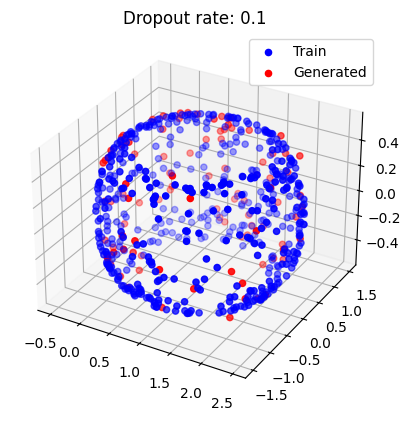

Mean distance to the center: 1.3515173196792603
Standard deviation of distance: 0.13311611115932465
Mean distance to the expected surface: 0.35151731967926025
Dropout rate: 0.2
Epoch: 0 Loss D.: 0.5874917507171631
Epoch: 0 Loss G.: 0.648514449596405
Epoch: 10 Loss D.: 0.20902884006500244
Epoch: 10 Loss G.: 4.26634407043457
Epoch: 20 Loss D.: 0.4957166314125061
Epoch: 20 Loss G.: 0.9405509233474731
Epoch: 30 Loss D.: 0.7053861021995544
Epoch: 30 Loss G.: 1.3215243816375732
Epoch: 40 Loss D.: 0.6293115615844727
Epoch: 40 Loss G.: 1.0643408298492432
Epoch: 50 Loss D.: 0.34977447986602783
Epoch: 50 Loss G.: 1.5985782146453857
Epoch: 60 Loss D.: 0.5903463363647461
Epoch: 60 Loss G.: 2.0218989849090576
Epoch: 70 Loss D.: 0.49212250113487244
Epoch: 70 Loss G.: 1.5033304691314697
Epoch: 80 Loss D.: 0.5375864505767822
Epoch: 80 Loss G.: 1.4842195510864258
Epoch: 90 Loss D.: 0.7013648152351379
Epoch: 90 Loss G.: 0.8258542418479919
Epoch: 100 Loss D.: 0.5062308311462402
Epoch: 100 Loss G.: 1.5875

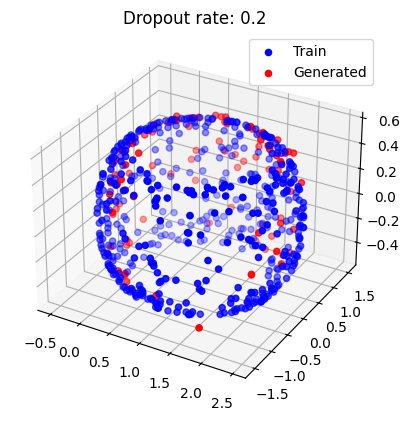

Mean distance to the center: 1.3172835111618042
Standard deviation of distance: 0.1382354348897934
Mean distance to the expected surface: 0.3172835111618042
Dropout rate: 0.5
Epoch: 0 Loss D.: 0.6128920316696167
Epoch: 0 Loss G.: 0.6436446905136108
Epoch: 10 Loss D.: 0.3317858576774597
Epoch: 10 Loss G.: 2.0084760189056396
Epoch: 20 Loss D.: 0.42320898175239563
Epoch: 20 Loss G.: 1.6185755729675293
Epoch: 30 Loss D.: 0.4674399495124817
Epoch: 30 Loss G.: 1.2216347455978394
Epoch: 40 Loss D.: 0.7050895094871521
Epoch: 40 Loss G.: 0.8410212993621826
Epoch: 50 Loss D.: 0.6589221954345703
Epoch: 50 Loss G.: 0.8655290007591248
Epoch: 60 Loss D.: 0.6242682933807373
Epoch: 60 Loss G.: 0.9674542546272278
Epoch: 70 Loss D.: 0.6829832792282104
Epoch: 70 Loss G.: 1.0467256307601929
Epoch: 80 Loss D.: 0.6314271688461304
Epoch: 80 Loss G.: 1.0225659608840942
Epoch: 90 Loss D.: 0.6516944766044617
Epoch: 90 Loss G.: 0.939100980758667
Epoch: 100 Loss D.: 0.6252642869949341
Epoch: 100 Loss G.: 0.930303

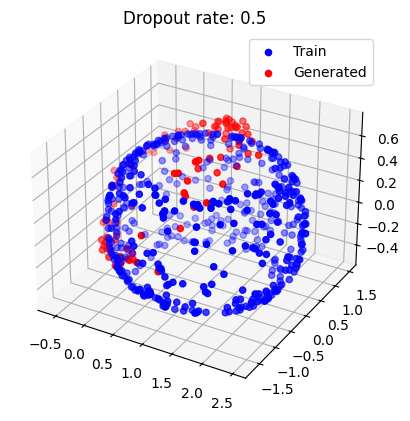

Mean distance to the center: 1.2186665534973145
Standard deviation of distance: 0.28982648253440857
Mean distance to the expected surface: 0.21866655349731445


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math


# Определение классов Discriminator с dropout
class Discriminator(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, hidden_param_num):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(hidden_param_num, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3))

    def forward(self, x):
        output = self.model(x)
        return output


dropout_rates = [0.1, 0.2, 0.5]

for dropout_rate in dropout_rates:
    random.seed(17)
    torch.manual_seed(19)

    print("="*89)
    print(f"Dropout rate: {dropout_rate}")

    discriminator = Discriminator(dropout_rate)
    generator = Generator(hidden_param_num)
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

    # для каждой эпохи:
    for epoch in range(num_epochs):
        for n in range(0, len(train_dataset), batch_size):
            real_samples = train_dataset[n:n + batch_size]
            real_samples_labels = torch.ones((real_samples.size(0), 1))
            latent_space_samples = torch.randn((batch_size, hidden_param_num))
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros((batch_size, 1))
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

            # обучение дискриминатора
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

            # данные для обучения генератора
            latent_space_samples = torch.randn((batch_size, hidden_param_num))
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()

        # выводим значения функций потерь
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator.item()}")

    # генерация примеров точек на торе
    latent_space_samples = torch.randn((100, hidden_param_num))
    generated_samples = generator(latent_space_samples).detach()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(train_dataset[:, 0], train_dataset[:, 1], train_dataset[:, 2], color='b', label='Train')
    ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], color='r', label='Generated')
    ax.legend()
    plt.title(f'Dropout rate: {dropout_rate}')
    plt.show()

    # оценка расстояний
    distances = torch.sqrt((generated_samples[:, 0] - R)**2 +
                           (generated_samples[:, 1])**2 +
                           (generated_samples[:, 2])**2)

    mean_distance = torch.mean(distances)
    std_distance = torch.std(distances)

    # ожидаемое близкое расстояние от центра
    expected_distance = R
    mean_distance_to_surface = mean_distance - expected_distance

    print(f"Mean distance to the center: {mean_distance.item()}")
    print(f"Standard deviation of distance: {std_distance.item()}")
    print(f"Mean distance to the expected surface: {mean_distance_to_surface.item()}")

